# Electrical detector demo analysis

This notebook explores a simulated dataset from an electrical detector. The generator produces a multi-channel time series with drift, noise, and random event pulses.

Data file: `data/detector_readings.csv`

What we'll do:
- Load the dataset
- Quick peek at schema and basic stats
- Plot signal over time with event markers
- Aggregate event rates per minute by detector
- Check temperature vs. signal correlation


In [ ]:
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

DATA_FILE = Path('../data/demo_data.csv').resolve()
OUTPUT_DIR = Path('../output').resolve()
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

if not DATA_FILE.exists():
    # Generate on the fly if missing
    from generate_detector_data import generate_detector_data, save_detector_data
    df_tmp = generate_detector_data()
    save_detector_data(df_tmp, DATA_FILE)

# Load
parse_dates = ['timestamp']
df = pd.read_csv(DATA_FILE, parse_dates=parse_dates)

# Basic info
print('Rows:', len(df))
print('Detectors:', sorted(df.detector_id.unique()))
df.head()

Rows: 5000
Detectors: ['D1', 'D2', 'D3', 'D4']


,timestamp,sample_id,detector_id,temperature_C,bias_voltage_V,signal_mV,noise_mV,is_event,rolling_mean_mV,rolling_std_mV
0,2025-01-01 12:00:00.000,0,D1,21.981594,4.989948,50.000000,1.928218,0,50.000000,0.000000
1,2025-01-01 12:00:00.100,1,D1,22.149521,5.001250,49.734731,2.661021,0,49.867366,0.187573
2,2025-01-01 12:00:00.200,2,D1,22.173630,4.999620,50.052965,2.907898,0,49.929232,0.170512
3,2025-01-01 12:00:00.300,3,D1,22.287834,4.988762,49.701393,3.472747,0,49.872272,0.179890
4,2025-01-01 12:00:00.400,4,D1,22.157822,4.996274,49.675566,0.567716,0,49.832931,0.178911


In [2]:
# Summary stats per detector
summary = df.groupby('detector_id')['signal_mV'].agg(['mean', 'std', 'min', 'max']).round(2)
summary

,mean,std,min,max
detector_id,,,,
D1,51.01,2.63,48.44,70.82
D2,50.92,2.03,49.02,69.53
D3,50.88,1.91,49.14,68.26
D4,51.33,2.85,48.85,69.16


In [3]:
# Plot a time window for one detector with events
import matplotlib.dates as mdates

one = df[df['detector_id'] == 'D1'].copy()
# Focus on first 2 minutes for readability
start_ts = one['timestamp'].min()
mask = (one['timestamp'] >= start_ts) & (one['timestamp'] < start_ts + pd.Timedelta(minutes=2))
win = one.loc[mask]

fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(win['timestamp'], win['signal_mV'], label='signal (mV)', color='#1f77b4', lw=1)
# Mark events
ev = win[win['is_event'] == 1]
ax.scatter(ev['timestamp'], ev['signal_mV'], color='crimson', s=20, label='events', zorder=3)

ax.set_title('Detector D1 — signal with events (first 2 minutes)')
ax.set_ylabel('mV')
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))
ax.grid(True, alpha=0.3)
ax.legend()
fig.tight_layout()
fig.savefig(OUTPUT_DIR / 'd1_signal_window.png', dpi=150)
plt.close(fig)

print('Saved figure:', OUTPUT_DIR / 'd1_signal_window.png')

Saved figure: /Users/andrew/Documents/PROGRAM_LOCAL/single_line/output/d1_signal_window.png


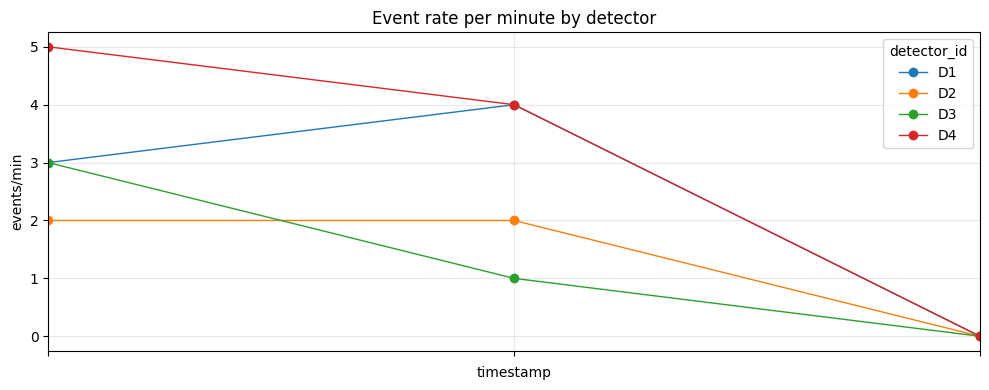

Saved figure: /Users/andrew/Documents/PROGRAM_LOCAL/single_line/output/event_rate_per_min.png


In [6]:
# Event rate per minute, by detector
rate = (
    df.set_index('timestamp')
      .groupby('detector_id')['is_event']
      .resample('1min').sum()
      .rename('events_per_min')
      .reset_index()
)

pivot = rate.pivot(index='timestamp', columns='detector_id', values='events_per_min').fillna(0)
ax = pivot.plot(figsize=(10, 4), marker='o', lw=1)
ax.set_title('Event rate per minute by detector')
ax.set_ylabel('events/min')
ax.grid(True, alpha=0.3)
fig = ax.get_figure()
fig.tight_layout()
fig.savefig(OUTPUT_DIR / 'event_rate_per_min.png', dpi=150)
plt.show()


print('Saved figure:', OUTPUT_DIR / 'event_rate_per_min.png')

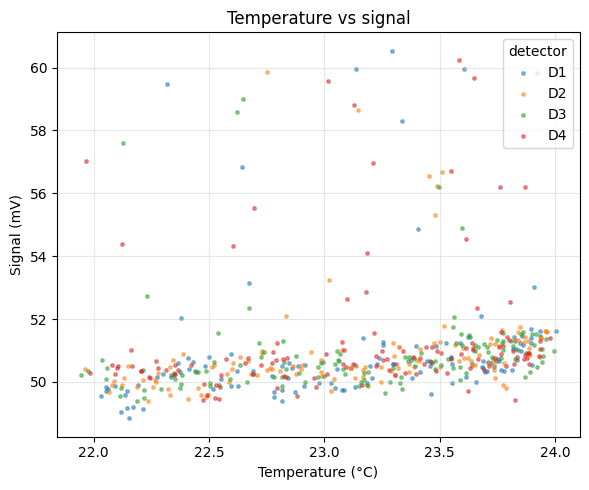

Saved figure: /Users/andrew/Documents/PROGRAM_LOCAL/single_line/output/temp_vs_signal.png


In [7]:
# Temperature vs signal (downsample to 1s to reduce points)
agg = (
    df.set_index('timestamp')
      .groupby('detector_id')[['signal_mV', 'temperature_C']]
      .resample('1s').mean()
      .reset_index()
)

fig, ax = plt.subplots(figsize=(6, 5))
for det, sub in agg.groupby('detector_id'):
    ax.scatter(sub['temperature_C'], sub['signal_mV'], s=6, alpha=0.5, label=det)
ax.set_title('Temperature vs signal')
ax.set_xlabel('Temperature (°C)')
ax.set_ylabel('Signal (mV)')
ax.grid(True, alpha=0.3)
ax.legend(title='detector')
fig.tight_layout()
fig.savefig(OUTPUT_DIR / 'temp_vs_signal.png', dpi=150)
plt.show()

print('Saved figure:', OUTPUT_DIR / 'temp_vs_signal.png')